In [1]:
pip install -U "jax[cuda12]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.3
    Uninstalling jax-cuda12-pjrt-0.5.3:
      Successfully uninstalled jax-cuda12-pjrt-0.5.3
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.5.3
    Uninstalling jax-cud

In [19]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import cupy as cp

import pandas as pd

import matplotlib.pyplot as plt

import time

In [3]:
gpu = cp.cuda.Device()
print("GPU ID:", gpu.id)
print("GPU name:", cp.cuda.runtime.getDeviceProperties(gpu.id)['name'])

GPU ID: 0
GPU name: b'Tesla T4'


In [4]:


def gelu_cp(x):
    return 0.5 * x * (1 + cp.tanh(cp.sqrt(2 / cp.pi) * (x + 0.044715 * x**3)))

def lnorm_cp(x, eps=1e-5):
    mean = cp.mean(x, axis=0, keepdims=True)
    var = cp.var(x, axis=0, keepdims=True)
    return (x - mean) / cp.sqrt(var + eps)

def softmax_cp(x, axis=-1):

    x_max = cp.max(x, axis=axis, keepdims=True)
    e_x = cp.exp(x - x_max)
    return e_x / cp.sum(e_x, axis=axis, keepdims=True)

def matmul_cp(a, b):

    return a @ b



def attention_per_head_cp(K, Q, V, l, ddh, b, h):
    lb = l * b
    E2 = cp.zeros((K.shape[0], lb), dtype=cp.float32)

    K_i32 = K.astype(cp.float32)
    Q_i32 = Q.astype(cp.float32)
    V_i32 = V.astype(cp.float32)

    for j in range(b):
        for i in range(h):
            indJ = j * l
            indI2 = i * ddh

            K_slice = K_i32[indI2:indI2+ddh, indJ:indJ+l]
            Q_slice = Q_i32[indI2:indI2+ddh, indJ:indJ+l]

            E1 = K_slice.T @ Q_slice
            E1 = E1 / cp.sqrt(ddh)
            E1 = softmax_cp(E1)

            V_slice = V_i32[indI2:indI2+ddh, indJ:indJ+l]
            result = V_slice @ E1

            E2[indI2:indI2+ddh, indJ:indJ+l] = result

    return E2


def mha_output_cp(WO, E2, EI):

    AO = EI + WO @ E2
    AO= lnorm_cp(AO)
    return AO

def ffn_forward_cp(W1, W2, AO):

    E3b = W1 @ AO
    E3 = gelu_cp(E3b)
    EOb = W2 @ E3b
    EO = lnorm_cp(EOb + AO)
    return EOb



In [5]:


def matmul_jax(a, b):
    result = a @ b
    return result

def attention_per_head_jax(K, Q, V, l, ddh, b, h):

    lb = l*b
    E2 = jnp.zeros((K.shape[0], lb), dtype=jnp.float32)

    def softmax(x, axis=-1):
        x_max = jnp.max(x, axis=axis, keepdims=True)
        e_x = jnp.exp(x - x_max)
        return e_x / jnp.sum(e_x, axis=axis, keepdims=True)

    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j*l
        indI2 = i*ddh

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l)).astype(jnp.float32)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l)).astype(jnp.float32)
        E1 = K_slice.T @ Q_slice
        E1 = E1 / jnp.sqrt(ddh)
        E1_normalized = softmax(E1, axis=0)
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l)).astype(jnp.float32)
        result = V_slice @ E1_normalized

        E2 = lax.dynamic_update_slice(E2, result, (indI2, indJ))
        return E2, None

    E2_init = jnp.zeros((d, lb), dtype=jnp.float32)
    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)

    return E2

def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)


def mha_output_jax(WO, E2, EI):
    AO = EI + WO @ E2
    AO= lnorm_jax(AO)
    return AO

def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))


def ffn_forward_jax(W1, W2, AO):
    E3b = W1 @ AO
    E3 = gelu_jax(E3b)
    EOb = W2 @ E3b
    EO = lnorm_jax(EOb + AO)
    return EO



In [6]:

b = 24
l = 128
d = 1024
h = 16


f = 4 * d
ddh = d // h
lb = b * l


In [7]:

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)


EI_jax = (jax.random.uniform(keys[0], (d, lb), dtype=jnp.float32)  )
WQ = (jax.random.uniform(keys[1], (d, d), dtype=jnp.float32) )
WK = (jax.random.uniform(keys[2], (d, d), dtype=jnp.float32) )
WV = (jax.random.uniform(keys[3], (d, d), dtype=jnp.float32) )
WO = (jax.random.uniform(keys[4], (d, d), dtype=jnp.float32) )
W1 = (jax.random.uniform(keys[5], (f, d), dtype=jnp.float32) )
W2 = (jax.random.uniform(keys[6], (d, f), dtype=jnp.float32) )




In [8]:
jax.config.update('jax_default_matmul_precision', 'highest')

In [9]:
EI_cp = cp.zeros( (d, lb),  dtype=cp.float32)
WQ_cp = cp.zeros( (d, d), dtype=cp.float32)
WK_cp = cp.zeros( (d, d),  dtype=cp.float32)
WV_cp = cp.zeros((d, d),  dtype=cp.float32)
WO_cp = cp.zeros( (d, d),  dtype=cp.float32)
W1_cp = cp.zeros( (f, d),  dtype=cp.float32)
W2_cp = cp.zeros((d, f),dtype=cp.float32)
results={}

In [10]:


results["CuPy"] = {}
Qc = matmul_cp(WQ_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
start = time.time()
Qc = matmul_cp(WQ_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_Q"] = end - start

start = time.time()
Kc = matmul_cp(WK_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_K"] = end - start

start = time.time()
Vc = matmul_cp(WV_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_V"] = end - start

start = time.time()
E2n = attention_per_head_cp(Kc, Qc, Vc, l, ddh, b, h)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["attention"] = end - start

start = time.time()
AOc = mha_output_cp(WO_cp, E2n, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["mha_output"] = end - start

start = time.time()
EOc = ffn_forward_cp(W1_cp, W2_cp, AOc)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["ffn"] = end - start

results["CuPy"]["total"] = sum(results["CuPy"].values())

In [11]:

# JAX withou JIT
results["JAX"] = {}


Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jax(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start

start = time.time()
E2j = attention_per_head_jax(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start

start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())

print(results["JAX"])


{'matmul_Q': 0.0027489662170410156, 'matmul_K': 0.002686738967895508, 'matmul_V': 0.002743959426879883, 'attention': 0.38639402389526367, 'mha_output': 0.41173624992370605, 'ffn': 0.9029974937438965, 'total': 1.7093074321746826}


In [13]:
results["JIT-COMP"] = {}

# JIT

matmul_jit= jax.jit(matmul_jax)
attention_per_head_jit = jax.jit(attention_per_head_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)



start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start



start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t

start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn

results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())


In [14]:
# JAX with JIT
results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start


start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t


start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

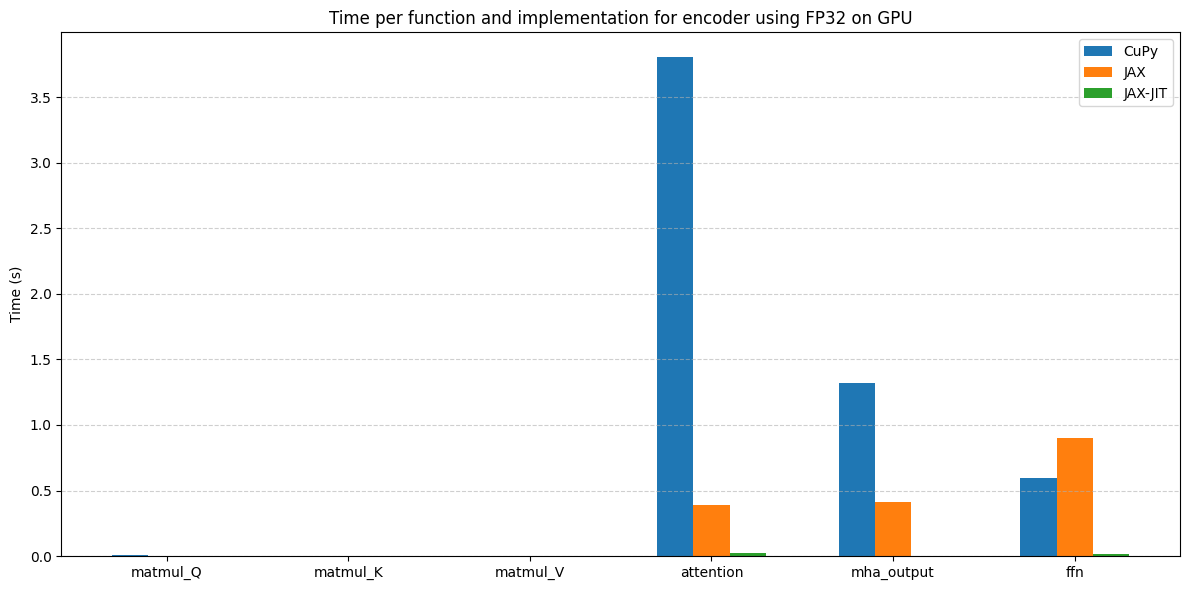

In [15]:

labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20
fig, ax = plt.subplots(figsize=(12, 6))


ax.bar(x - 1*width, [results["CuPy"][l] for l in labels], width, label='CuPy')
ax.bar(x + 0*width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Time (s)')
ax.set_title('Time per function and implementation for encoder using FP32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

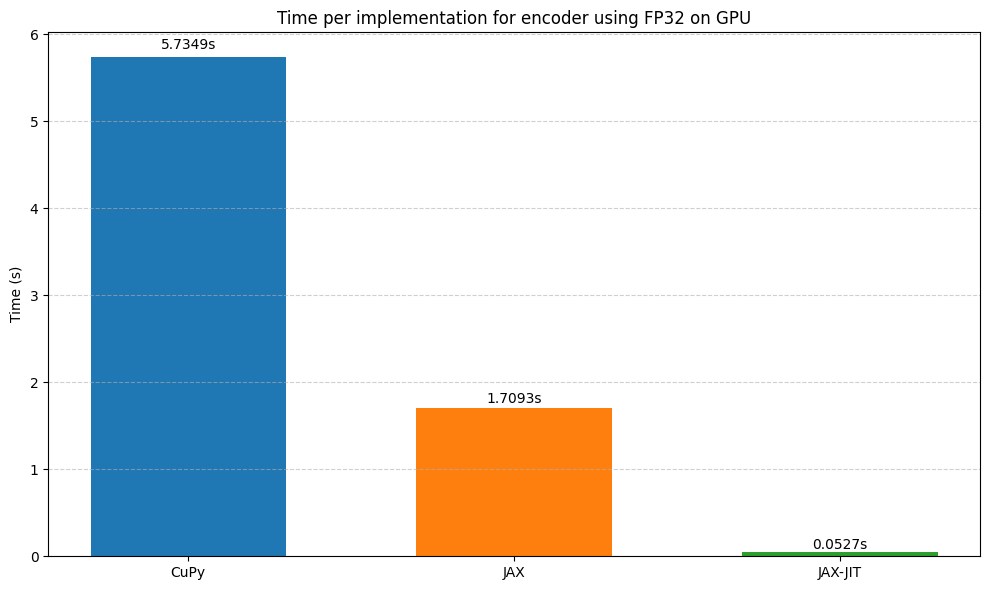

In [16]:

labels = ["CuPy", "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Time per implementation for encoder using FP32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

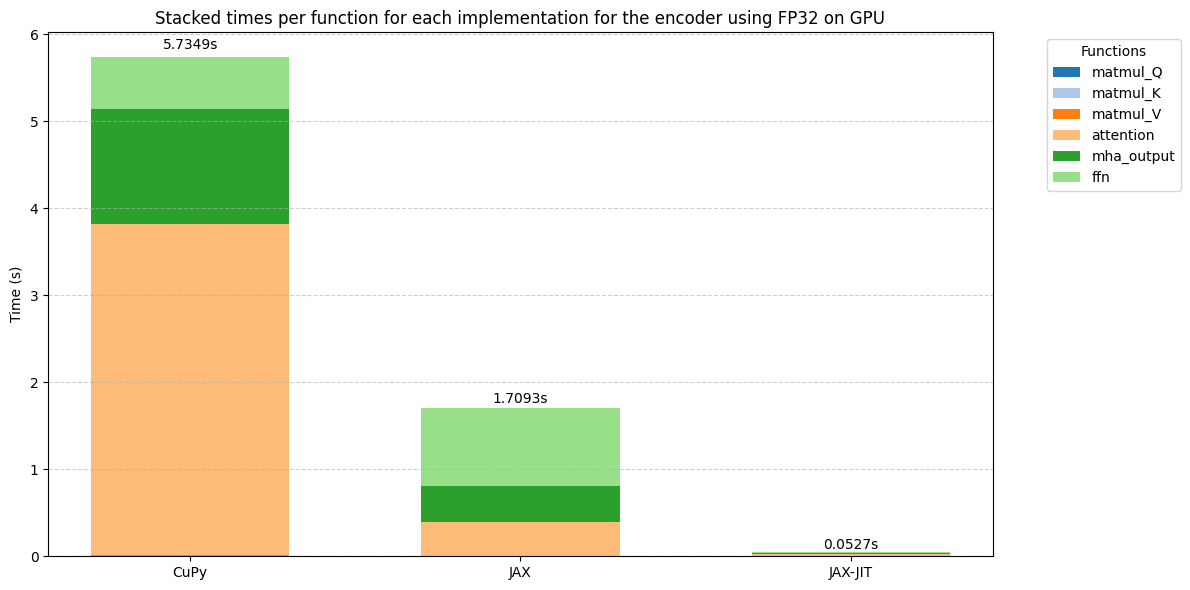

In [17]:

implementations = ["CuPy", "JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))


bottom = np.zeros(len(implementations))


for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values


for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')


ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the encoder using FP32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)


ax.legend(title="Functions", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [20]:
df = pd.DataFrame(results).T

In [21]:
df

,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
CuPy,0.005868,0.002648,0.002878,3.803818,1.323115,0.596534,5.734862
JAX,0.002749,0.002687,0.002744,0.386394,0.411736,0.902997,1.709307
JIT-COMP,0.024835,0.002786,0.002698,0.578528,0.537858,0.668883,1.815588
JAX-JIT,0.002779,0.002635,0.002686,0.022427,0.003284,0.018898,0.052708
